In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100
import seaborn as sns

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels
import statsmodels.stats.outliers_influence as sso

In [17]:
DSAP107 = pd.read_excel('DSAP107.xlsx')
DSAP108 = pd.read_excel('DSAP108.xlsx')
OR107 = pd.read_excel('OR107.xlsx')

In [28]:
DSAP107

,student_id,midterm,final,total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,watched_video,avg_playback_rate
0,64,0,0.0,4385.133333,0.178199,0,0,0,0,0,0,0,0,0,10,2,12,1.494139
1,65,0,0.0,3572.000000,0.092675,88,5,442,9,4,4,0,0,0,0,1,5,1.000000
2,66,82,76.0,36625.000000,1.033947,6685,171,7912,248,22,36,0,7,6,0,3,52,1.000000
3,67,79,79.0,18789.383333,0.963616,6459,116,6784,161,6,3,3,9,33,1,1,50,1.847426
4,68,52,57.0,13719.766667,0.673371,3958,83,6892,171,35,2,0,3,29,8,0,42,1.742595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,164,0,88.0,28485.866667,1.089812,5858,597,5365,333,69,18,0,2,11,11,11,53,1.376542
101,165,0,55.0,6125.250000,0.271872,2409,51,4293,53,10,5,0,0,0,0,14,19,1.626709
102,166,90,76.0,18766.033333,0.684335,3950,343,2600,103,22,5,0,3,13,10,4,35,1.279866
103,167,91,54.0,17117.583333,0.743504,3384,59,2689,38,3,3,0,6,15,8,18,50,1.565057


In [18]:
def check_coef(df, threshold=0):
    import seaborn as sns
    df_coef = df.corr()
    sns.heatmap(df.corr(), annot=True)

In [19]:
def scatter_plot(df,x_label, y_label):
    y = df[y_label].values
    for xi in x_label:
        x = df[xi].values
        _ = plt.plot(x, y, 'o', color = 'b')
        plt.xlabel(xi)
        plt.ylabel(y_label)
        plt.title(xi+" to "+y_label)
        plt.show()

In [20]:
# x_labels must be a list
def linear_regression(df, x_labels, y_label):
    x_param = ''
    for x in x_labels:
        x_param+="Q(\"{}\")+".format(x)
    x_param = x_param[:-1]
    y_label  = "Q(\""+y_label+"\")"
    df1_result = smf.ols(y_label+"~"+x_param, data = df).fit()
    print(df1_result.summary())
    return df1_result

In [21]:
def check_outlier(df, x_label, y_label, df1_result):
    import statsmodels.stats.outliers_influence as sso

    x = df[x_label].values
    st, data, ss2 = sso.summary_table(df1_result, alpha=0.05)
    y = data[:, 10]

    plt.plot(x, y, 'o', color = 'gray')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.show()
    return st, data, ss2

In [22]:
def check_influential_observ(df1, x_label, y_label, df1_result):
    st, data, ss2 = sso.summary_table(df1_result, alpha=0.05)
    x = df1[x_label].values
    cook_dist = data[:, 11]
    print(cook_dist)
    plt.plot(x, cook_dist, 'o', color = 'gray')
    plt.axhline(y=1, color="red")
    plt.show()

In [23]:
def check_norm(resid, bins='auto'):
    # Run Shapiro test
    stat, p = stats.shapiro(resid)
    print(f'Shapiro test: statistics = {stat:.4f}, p = {p:.4f}\n')
    
    # Draw historgram
    print('Histogram')
    plt.hist(resid, bins=bins)
    plt.show()
    
    # Draw QQ plot
    print('QQ plot')
    fig = sm.qqplot(resid, stats.norm, fit=True, line='45')
    plt.show()

In [24]:
def getEquation(df_result):
    print("y = ",end="")
    text = ''
    for name, coef in zip(df_result.params.index, df_result.params):
        text+="{:.3f} * {} + ".format(coef, name)
    text = text[:-2]
    print(text)

In [25]:
def reg_analysis(df, x_labels, y_label):
    df.fillna(value=0, inplace=True)
    display(df.describe())
    check_coef(df[x_labels])
    print("1 if larger than 0.5...")
    scatter_plot(df,x_labels, y_label)
    df_result = linear_regression(df, x_labels, y_label)
    getEquation(df_result)
    print("Residual Test...")
    print("Normality")
    check_norm(df_result.resid_pearson)
    print("Influential Observations")
    check_influential_observ(df, 'student_id', y_label, df_result)
    print("Outliers")
    st, data, ss2 = check_outlier(df, 'student_id', y_label, df_result)
    return st, data, ss2

## OR107

In [26]:
OR107.columns

Index(['student_id', 'project', 'final', 'total_watch_time', 'watch_freq',
       'backward_sec', 'backward_times', 'forward_sec', 'forward_times',
       'pause_freq', 'period 0', 'period 1', 'period 2', 'period 3',
       'period 4', 'period 5', 'most_watch_period', 'watched_video',
       'avg_playback_rate'],
      dtype='object')

,student_id,project,final,total_watch_time,watch_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq,period 0,period 1,period 2,period 3,period 4,period 5,watched_video,avg_playback_rate
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,129.000000,57.184096,44.554217,18548.041466,0.405121,4250.289157,117.048193,4427.433735,200.626506,49.132530,5.084337,0.759036,2.987952,5.554217,6.433735,9.060241,29.879518,1.136725
std,24.103942,45.662436,36.915610,15457.478642,0.335793,8015.716038,207.394869,8559.996863,423.617370,308.763378,7.121258,2.417368,5.623327,6.822225,7.143465,9.636502,22.440924,0.642992
min,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,108.500000,0.000000,0.000000,2009.816667,0.043900,11.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,1.025470
50%,129.000000,90.690000,54.000000,18924.783333,0.444005,1360.000000,39.000000,1427.000000,44.000000,4.000000,1.000000,0.000000,0.000000,3.000000,5.000000,6.000000,37.000000,1.351594
75%,149.500000,94.555000,78.000000,31491.175000,0.655524,4379.500000,116.500000,5828.000000,160.000000,12.000000,8.500000,0.000000,4.000000,8.500000,9.500000,14.000000,51.500000,1.493317
max,170.000000,98.500000,98.000000,63713.400000,1.391923,57193.000000,1015.000000,49991.000000,2811.000000,2811.000000,26.000000,13.000000,27.000000,33.000000,32.000000,39.000000,65.000000,1.990651


1 if larger than 0.5...


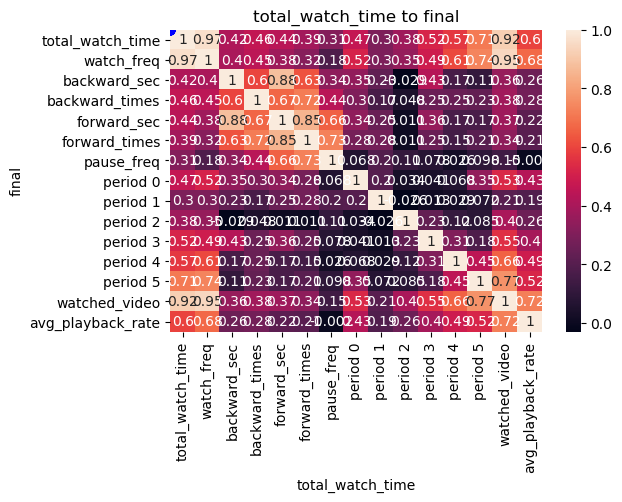

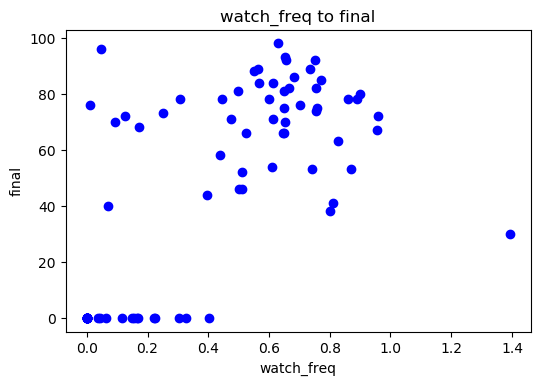

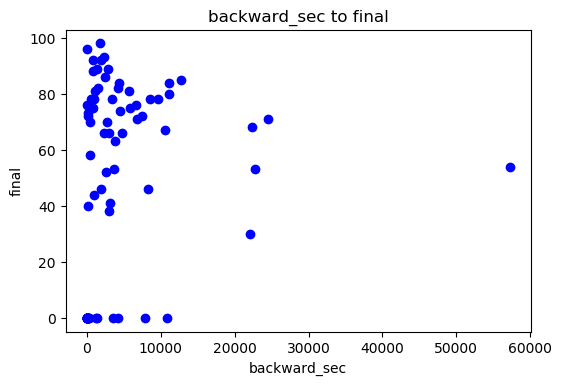

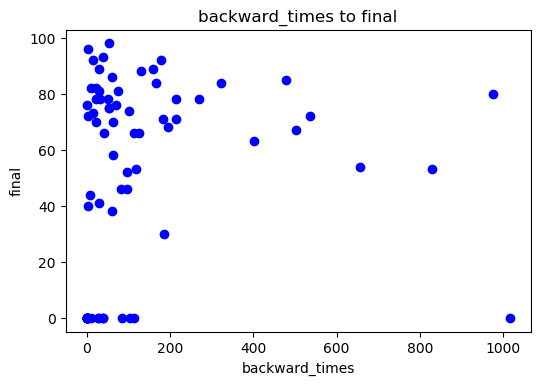

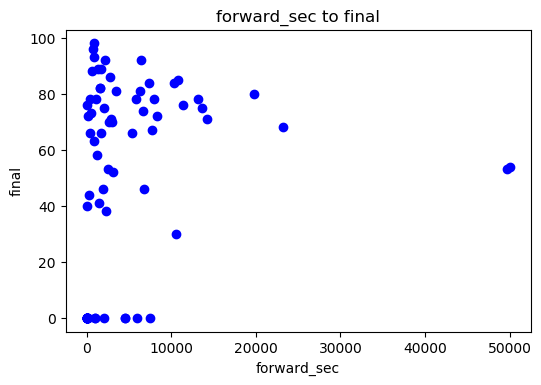

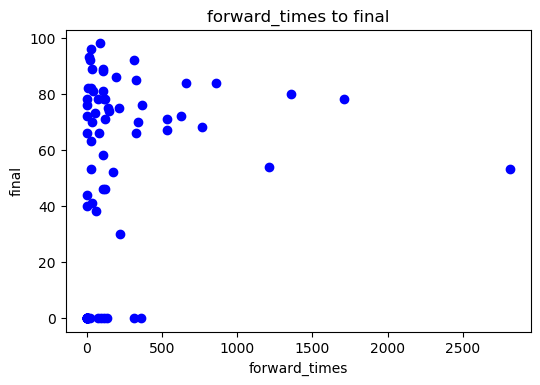

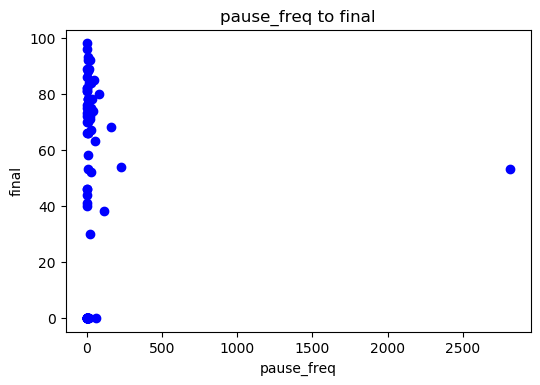

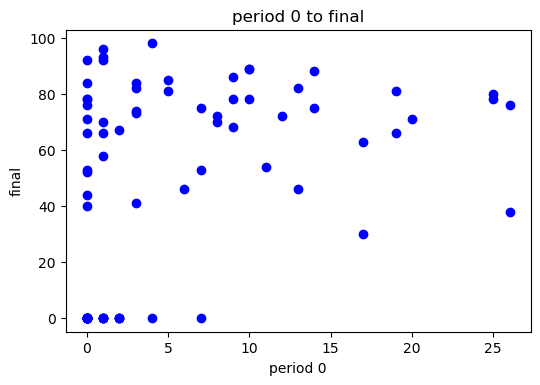

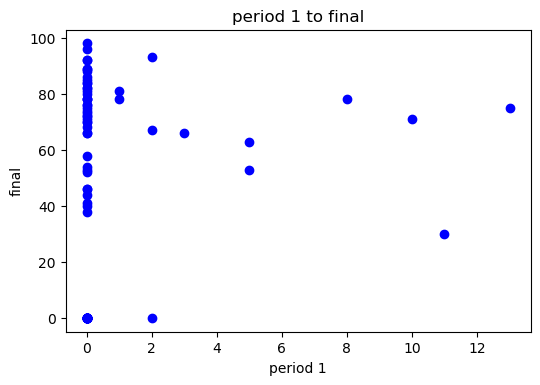

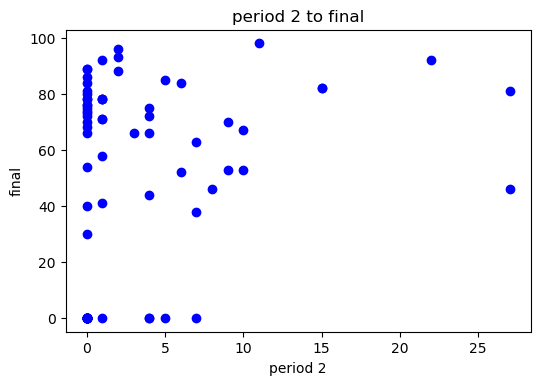

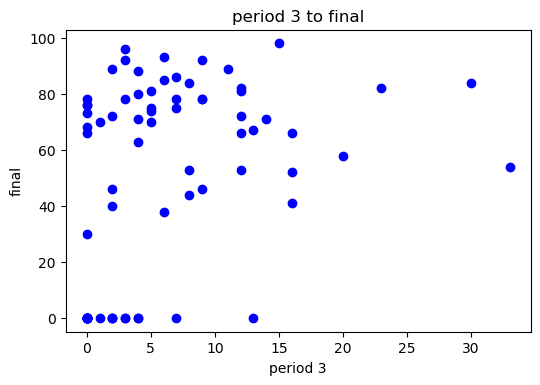

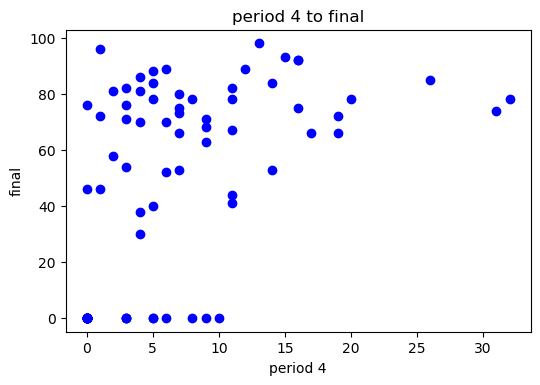

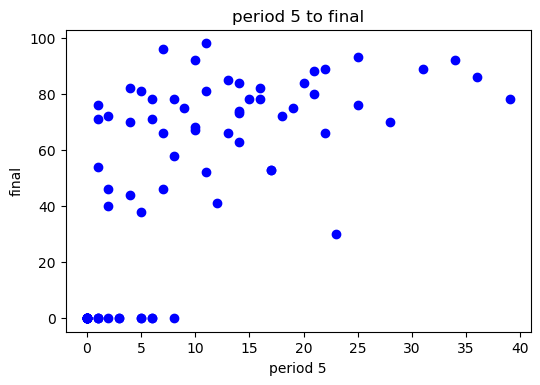

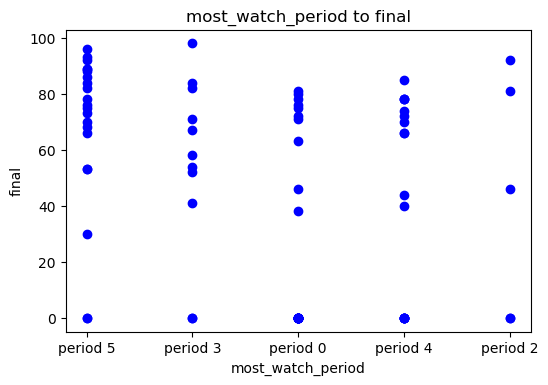

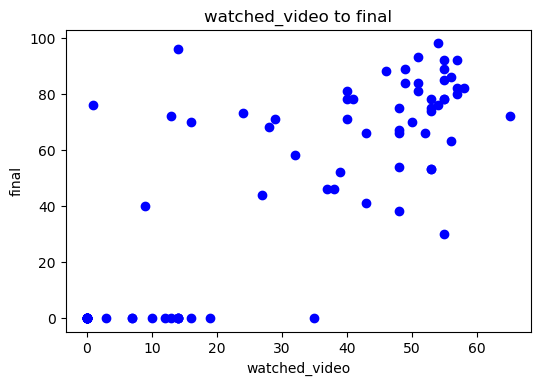

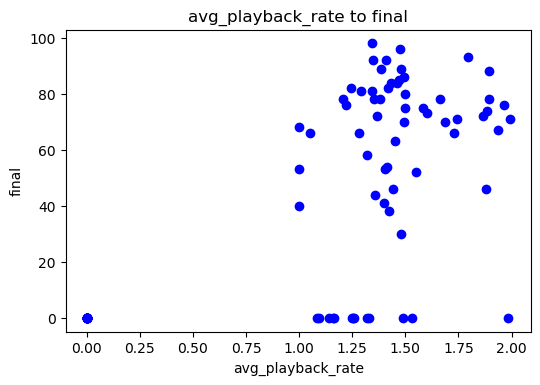

                            OLS Regression Results                            
Dep. Variable:             Q("final")   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     15.23
Date:                Sun, 14 Jun 2020   Prob (F-statistic):           1.11e-16
Time:                        22:00:19   Log-Likelihood:                -347.70
No. Observations:                  83   AIC:                             733.4
Df Residuals:                      64   BIC:                             779.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

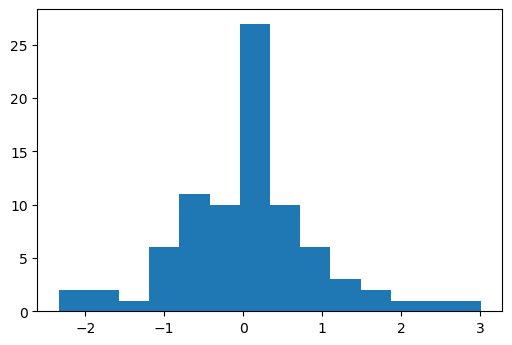

QQ plot


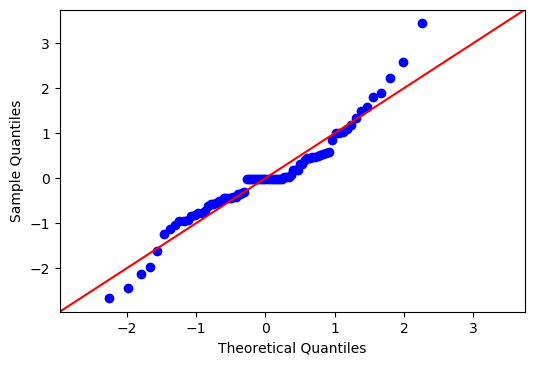

Influential Observations
[4.17512435e-02 4.79667348e-03 1.31784868e-06 1.31784868e-06
 1.31784868e-06 1.31784868e-06 1.31784868e-06 5.91193189e-03
 1.65270765e-02 3.59462145e-02 1.10485883e-01 1.31784868e-06
 4.14679880e-02 2.47321026e-03 1.73947708e-03 6.64354153e-03
 4.38082671e-06 6.43774859e-02 5.44829597e-03 1.31784868e-06
 2.05832114e+00 1.31784868e-06 1.51133520e-03 7.77382453e-03
 1.31784868e-06 2.94301126e-03 1.31784868e-06 4.53995141e-02
 4.76584472e-03 1.53911776e-04 8.42683185e-03 2.28267570e-03
 1.03543004e-01 4.50073423e-03 1.31784868e-06 1.50264901e-02
 1.31784868e-06 9.41437024e-02 7.59366027e-03 3.28133665e-03
 1.35461833e-03 1.55319729e-03 3.09469557e-03 7.15294858e-04
 4.95203354e-02 8.89865624e-03 1.26713586e-01 2.19964571e-03
 6.96482028e-02 3.21422698e-03 8.25411894e-03 8.70086752e-03
 2.30662894e-02 2.89173080e-03 8.06539751e-02 1.31784868e-06
 1.31784868e-06 2.65685324e-03 1.25279520e-01 1.31250589e-02
 4.08099735e-02 2.81600266e-03 1.77031972e-02 5.15716873e-03

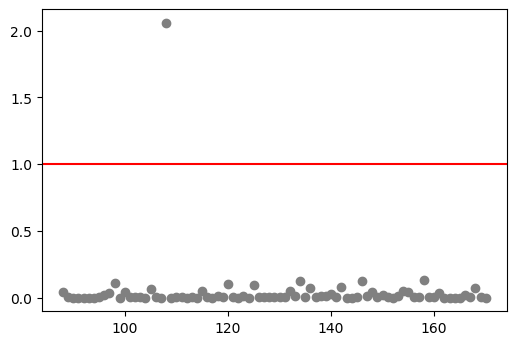

Outliers


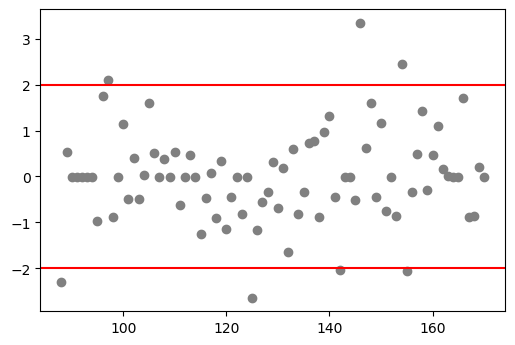

In [27]:
x_labels = list(OR107.columns[3:])
y_label = "final"
st, data, ss2 = reg_analysis(OR107, x_labels, y_label)

In [ ]:
pd.DataFrame(columns=ss2)

## Check the outliers

In [371]:
outliers = pd.DataFrame(data[ (abs(data[:,10]))>2])

In [372]:
outliers

,0,1,2,3,4,5,6,7,8,9,10,11
0,49.0,30.0,89.456950,14.935340,59.697636,119.216264,27.526030,151.387870,-59.456950,22.801774,-2.607558,0.324129
1,59.0,76.0,22.588566,5.623666,11.383167,33.793965,-32.867570,78.044702,53.411434,26.671326,2.002579,0.019810
2,67.0,96.0,30.491686,6.545707,17.449080,43.534292,-25.364662,86.348035,65.508314,26.460139,2.475736,0.041677


## check influential observations

In [373]:
influ_obs = pd.DataFrame(data[(abs(data[:,11]))>1])

In [374]:
influ_obs

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.0,53.0,74.961382,24.638539,25.868021,124.054744,1.749497,148.173268,-21.961382,11.658801,-1.883674,1.760724


## Extract outliers and influential data

In [375]:
OR107.loc[list(outliers[0])+list(influ_obs[0])]

,student_id,project,final,total_watch_time,avg_playback_rate,avg_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq
49.0,137,78.78,73.0,10342.333333,1.600413,0.239367,151,16,500,57,119
59.0,147,90.80,71.0,22731.500000,1.741416,0.572459,24491,222,14296,544,1097
67.0,155,96.50,53.0,35500.833333,1.403376,0.720488,3683,125,2516,31,424
21.0,109,0.00,0.0,0.000000,0.000000,0.000000,0,0,0,0,0


In [387]:
OR107_extract = OR107[~OR107.index.isin(outliers[0])]

## DSAP107

,student_id,midterm,final,total_watch_time,avg_playback_rate,avg_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,116.000000,47.838095,47.890476,18651.977256,1.436895,0.805038,6169.209524,172.847619,5696.952381,239.619048,452.742857
std,30.454885,41.221989,34.290121,12435.747678,0.459068,0.518082,8287.920958,206.699837,7815.918138,410.113314,488.764377
min,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,0.000000,0.000000,12851.733333,1.248772,0.559133,722.000000,32.000000,895.000000,13.000000,123.000000
50%,116.000000,73.000000,60.000000,18766.033333,1.480752,0.800567,3889.000000,75.000000,2615.000000,74.000000,293.000000
75%,142.000000,85.000000,76.000000,26227.966667,1.745431,1.082840,8919.000000,272.000000,6939.000000,311.000000,667.000000
max,168.000000,98.000000,91.500000,69769.233333,2.380491,2.785461,47475.000000,905.000000,46388.000000,2368.000000,2538.000000


fill 0 if is NaN
1 if larger than 0.5...


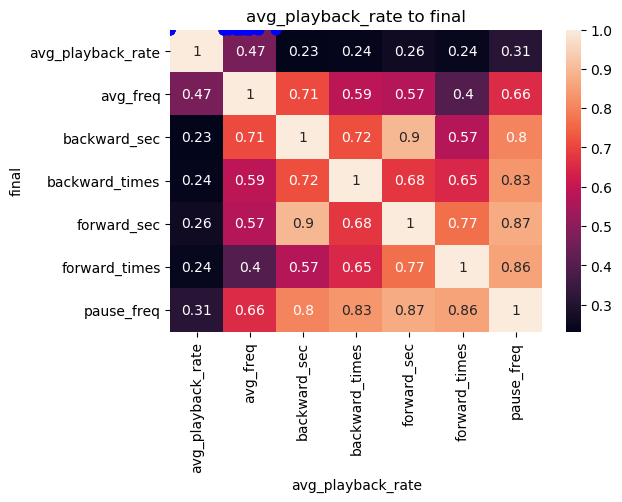

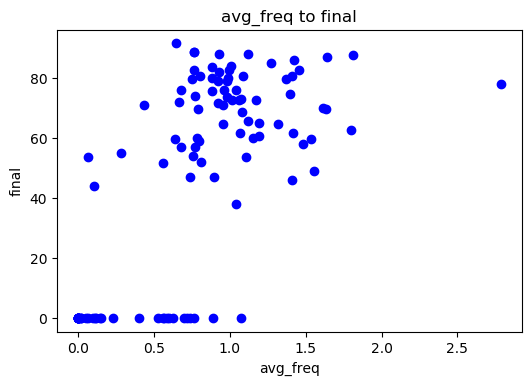

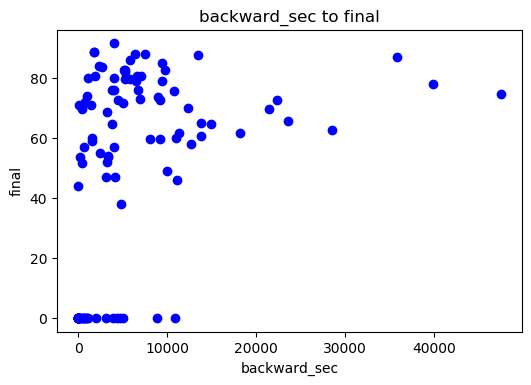

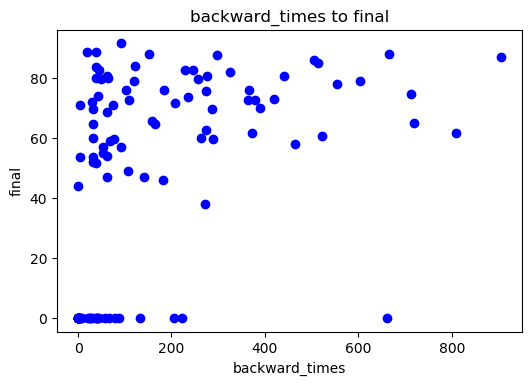

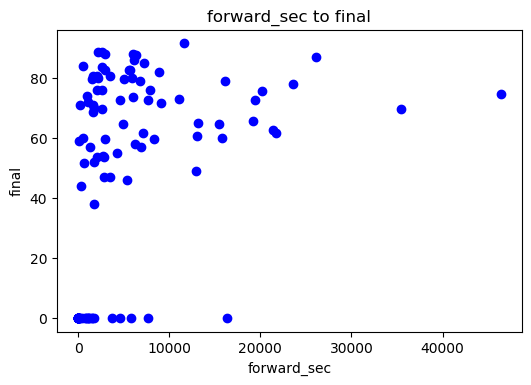

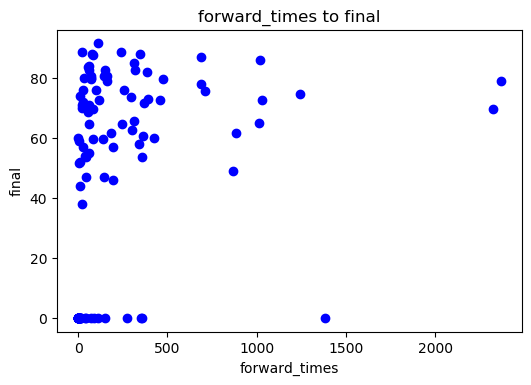

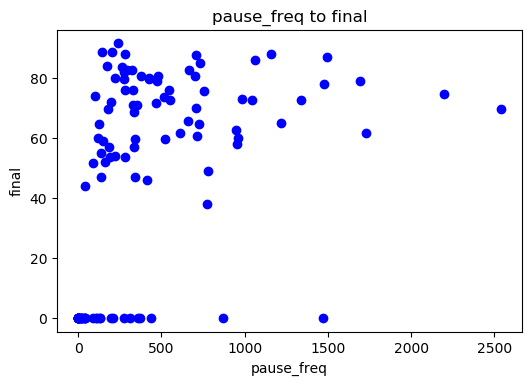

                            OLS Regression Results                            
Dep. Variable:             Q("final")   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     16.60
Date:                Sat, 06 Jun 2020   Prob (F-statistic):           3.18e-14
Time:                        14:13:31   Log-Likelihood:                -478.30
No. Observations:                 105   AIC:                             972.6
Df Residuals:                      97   BIC:                             993.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4

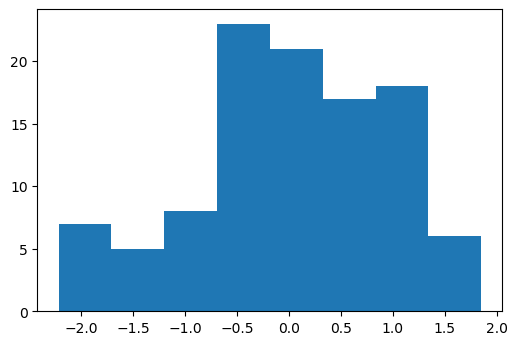

QQ plot


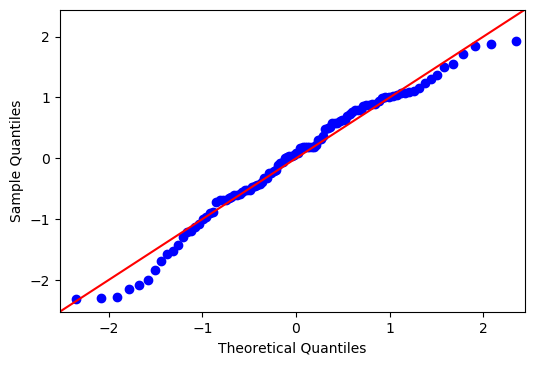

Influential Observations
[7.04166104e-03 1.01509195e-03 3.00897056e-03 1.80402876e-03
 9.66630701e-05 1.08656898e-02 2.94582123e-03 2.05647955e-02
 2.59260858e-03 1.17782954e-03 8.36851767e-05 8.96481369e-04
 7.82946052e-03 2.60314345e-03 3.97600202e-02 1.00365186e-03
 4.00423288e-04 5.01848221e-03 6.24009952e-03 1.42515104e-02
 4.50914687e-04 1.92647398e-03 9.89496128e-02 2.85728943e-04
 1.46168224e-02 9.93910222e-03 8.81028669e-03 1.56704678e-03
 2.13623776e-04 2.85885351e-03 3.34913902e-03 2.20847390e-02
 3.57929868e-04 4.32800607e-03 2.45687038e-01 4.89979794e-06
 1.07128320e-02 4.90346524e-04 1.07486070e-02 1.17893827e-02
 2.27885219e-02 4.73458344e-05 1.17405690e-03 2.56787999e-03
 4.54688004e-03 3.77874082e-04 3.15259035e-03 1.49378421e-03
 4.90346524e-04 1.18322976e-03 3.62640473e-02 6.95800275e-03
 6.21037164e-02 1.04020139e-05 1.68130331e-02 1.42990917e-03
 4.90346524e-04 6.36961236e-03 8.03561210e-02 7.70782938e-04
 3.49595729e-03 8.48847400e-04 1.01213664e-02 1.75960997e-03

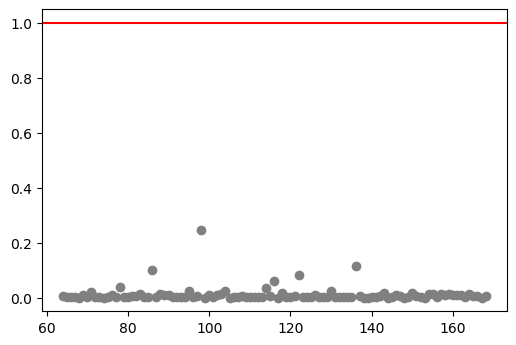

Outliers


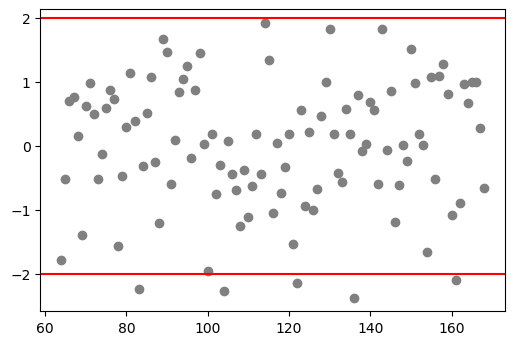

In [358]:
x_labels = ['avg_playback_rate', 'avg_freq', 'backward_sec', 'backward_times','forward_sec', 'forward_times', 'pause_freq']
y_label = "final"
st, data, ss2 = reg_analysis(DSAP107, x_labels, y_label)

## Check the outliers

In [359]:
outliers = pd.DataFrame(data[ (abs(data[:,10]))>2])

In [360]:
outliers

,0,1,2,3,4,5,6,7,8,9,10,11
0,20.0,0.0,52.696431,3.592303,45.566704,59.826158,4.633240,100.759622,-52.696431,23.677691,-2.225573,0.014252
1,41.0,0.0,53.150141,4.448478,44.321144,61.979137,4.805664,101.494618,-53.150141,23.531866,-2.258645,0.022789
2,59.0,0.0,48.091943,8.388700,31.442696,64.741190,-2.271087,98.454972,-48.091943,22.431393,-2.143957,0.080356
3,73.0,0.0,52.486283,8.965233,34.692777,70.279789,1.733489,103.239078,-52.486283,22.207258,-2.363474,0.113801
4,98.0,0.0,49.592437,2.955875,43.725844,55.459030,1.700327,97.484547,-49.592437,23.765532,-2.086738,0.008420


In [361]:
DSAP107.loc[list(outliers[0])]

,student_id,midterm,final,total_watch_time,avg_playback_rate,avg_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq
20.0,84,0,0.0,50.000000,1.000000,0.001417,150,4,895,17,24
41.0,105,0,71.5,21754.166667,1.500816,0.925294,5024,208,9120,370,469
59.0,123,73,60.0,20873.916667,1.326632,0.784809,1554,33,521,1,119
73.0,137,92,80.5,30221.866667,1.272919,1.090265,7127,442,3551,164,703
98.0,162,0,60.5,29284.483333,1.432943,1.189259,13758,522,13017,363,715


## check influential observations

In [362]:
influ_obs = pd.DataFrame(data[ (abs(data[:,11]))>1])

In [363]:
influ_obs

,0,1,2,3,4,5,6,7,8,9,10,11


In [364]:
DSAP107.loc[list(influ_obs[0])]

,student_id,midterm,final,total_watch_time,avg_playback_rate,avg_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq


## Extract outliers and influential data

In [365]:
DSAP107.loc[list(outliers[0])+list(influ_obs[0])]

,student_id,midterm,final,total_watch_time,avg_playback_rate,avg_freq,backward_sec,backward_times,forward_sec,forward_times,pause_freq
20.0,84,0,0.0,50.000000,1.000000,0.001417,150,4,895,17,24
41.0,105,0,71.5,21754.166667,1.500816,0.925294,5024,208,9120,370,469
59.0,123,73,60.0,20873.916667,1.326632,0.784809,1554,33,521,1,119
73.0,137,92,80.5,30221.866667,1.272919,1.090265,7127,442,3551,164,703
98.0,162,0,60.5,29284.483333,1.432943,1.189259,13758,522,13017,363,715


In [366]:
DSAP107_extract = DSAP107[~DSAP107.index.isin(outliers[0])]